### Lab-I
#### EE5175 Image Signal Processing

Author **Ayush Mukund Jamdar**

Roll Number **EE20B018**

In this Lab, we implement elementary **Geometric Transforms** - translation, rotation, and scaling. 

In [1]:
import numpy as np
from PIL import Image # for image loading and saving
from IPython.display import display

We begin by defining some basic functions that will be required throughout. 

In [2]:
# Convert a grayscale png/jpg image to a numpy array
# of ints 0 to 256
def image2arr(filename):
    image = Image.open(filename)
    return np.array(image)


# Save a 2D numpy array as an image in jpg/png
def saveArrAsImage(image_array, filepath, file_format):
    image = Image.fromarray(image_array)
    # image.show()
    image.save(filepath, file_format)
    return

# Display a 2D numpy array as an image in the notebook
def display_image(image_array):
    image = Image.fromarray(image_array)
    display(image)

#### Bilinear Interpolation
We perform Target-to-Source Mapping to avoid any unwanted blank pixels that may appear if the mapping is done from Source to Target. 

This means that for every pixel of the Target image, we find the corresponding pixel from the Source. This correspondence is decided by the transform. It is basically the *inverse* of the transform function. This part will be coded later. For now, the interpolator takes the nearest four pixels and assigns a weighted average of their intensities to the central pixel.

In [3]:
# Bilinear Interpolation for Target to Source Mapping.  
def bilinear_interpolation(xs, ys, xt, yt, target_array, source_array):
    xs_flr = int(np.floor(xs))
    ys_flr = int(np.floor(ys))

    if (0 <= xs < source_array.shape[0] - 1) and (
        0 <= ys < source_array.shape[1] - 1
    ):
        a = xs - xs_flr
        b = ys - ys_flr
        target_array[xt, yt] = (
            (1 - a) * (1 - b) * source_array[xs_flr, ys_flr]
            + (1 - a) * b * source_array[xs_flr, ys_flr + 1]
            + a * (1 - b) * source_array[xs_flr + 1, ys_flr]
            + a * b * source_array[xs_flr + 1, ys_flr + 1]
        )

    return

### 1. Translation

#### 1.1 Experiment
We need to translate an image by $t_x$ and $t_y$ pixels. Note that these values are floats in general. 

$$ x_s = x_t - t_x $$
$$ y_s = y_t - t_y $$

This is how we find the source pixel $(x_s, y_s)$ which is going to share its intensity with $(x_t, y_t)$. Since we have non-integer points, we perform bilinear interpolation to complete the mapping. 

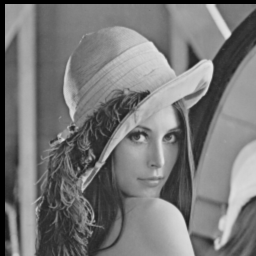

In [4]:
def translate(tx, ty, source_filename, dest_filepath, file_format):
    im_arr = image2arr(source_filename)

    translated_image = np.zeros(im_arr.shape).astype(np.uint8)

    for i in range(im_arr.shape[0]):
        for j in range(im_arr.shape[1]):
            xs = i - tx
            ys = j - ty
            
            bilinear_interpolation(xs, ys, i, j, translated_image, im_arr)

    display_image(translated_image)
    saveArrAsImage(translated_image, dest_filepath, file_format)
    return

translate(
        tx=3.75,
        ty=4.3,
        source_filename="lena_translate.png",
        dest_filepath="lena_translated.png",
        file_format="PNG",
    )

#### 1.2 Results
The image is shifted rightwards and downwards since both $(t_x, t_y)$ are positive. Note that indices are such that $(0, 0)$ is at the top left corner of the image. $x$-axis is along the rows of the image and $y$-axis along the columns.

Just for another experiment, we negate the values of translation. 

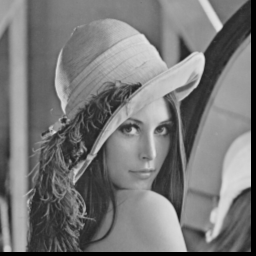

In [5]:
translate(
        tx=-3.75,
        ty=-4.3,
        source_filename="lena_translate.png",
        dest_filepath="lena_translated_neg.png",
        file_format="PNG",
    )

### 2. Rotation

#### 2.1 Experiment 
We wish to correct mistakes of ancient architects in this experiment. We use the rotation matrix. 

**Catch**: The rotation has to be performed about the center and hence before using the rotation matrix, we must shift the origin. Once, the rotated coordinates are obtained, we shift the origin back to the upper left corner.

$$ (x_s - O_x, y_s - O_y) = R^{-1} \cdot (x_t - O_x, y_t - O_y) $$

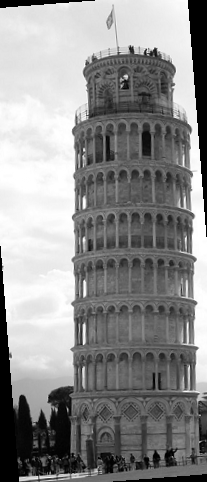

In [6]:
def rotate(theta, source_filename, dest_filepath, file_format):
    image_array = image2arr(source_filename)
    # theta is in degrees

    # rotation matrix
    R = np.array(
        [
            [np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))],
            [-np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta))],
        ]
    )

    rotated_image = np.zeros(image_array.shape).astype(np.uint8)

    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            # shift origin from corner to center of image
            xs_shifted, ys_shifted = np.matmul(
                np.linalg.inv(R),
                np.array((i - image_array.shape[0] / 2, j - image_array.shape[1] / 2)),
            )

            # shift origin back to image corner
            xs = xs_shifted + image_array.shape[0] / 2
            ys = ys_shifted + image_array.shape[1] / 2

            if (0 <= xs < image_array.shape[0] - 1) and (
                0 <= ys < (image_array.shape[1] - 1)
            ):
                xs_flr = int(np.floor(xs))
                ys_flr = int(np.floor(ys))

                a = xs - xs_flr
                b = ys - ys_flr
                rotated_image[i, j] = (
                    (1 - a) * (1 - b) * image_array[xs_flr, ys_flr]
                    + (1 - a) * b * image_array[xs_flr, ys_flr + 1]
                    + a * (1 - b) * image_array[xs_flr + 1, ys_flr]
                    + a * b * image_array[xs_flr + 1, ys_flr + 1]
                )

    # display
    display_image(rotated_image)

    # save as image
    saveArrAsImage(rotated_image, dest_filepath, file_format)
    return

rotate(-4.5, "pisa_rotate.png", "pisa_rotated.png", "PNG")

#### 2.2 Results
Approximately **$4.5 \degree$** is the tilt. The image is rotated about the center as evidenced by the black triangles at all corners.  

### 3. Scaling
 

#### 3.1 Experiment
Zooming in or zooming out. The interpolation technique is actually required in this section. The process is similar.

In [7]:
def scale(xscaling_factor, yscaling_factor, source_filename, dest_filepath, file_format):
    im_arr = image2arr(source_filename)

    scaled_image = np.zeros(im_arr.shape).astype(np.uint8)

    for i in range(im_arr.shape[0]):
        for j in range(im_arr.shape[1]):
            xs = i / xscaling_factor
            ys = j / yscaling_factor
            xs_flr = int(np.floor(xs))
            ys_flr = int(np.floor(ys))

            if xs_flr < im_arr.shape[0] and ys_flr < im_arr.shape[1]:
                a = xs - xs_flr
                b = ys - ys_flr
                scaled_image[i, j] = (
                    (1 - a) * (1 - b) * im_arr[xs_flr, ys_flr]
                    + (1 - a) * b * im_arr[xs_flr, ys_flr + 1]
                    + a * (1 - b) * im_arr[xs_flr + 1, ys_flr]
                    + a * b * im_arr[xs_flr + 1, ys_flr + 1]
                )

    display_image(scaled_image)
    saveArrAsImage(scaled_image, dest_filepath, file_format)
    return

We first scale both axes by $0.8$, which is a zoom out. 

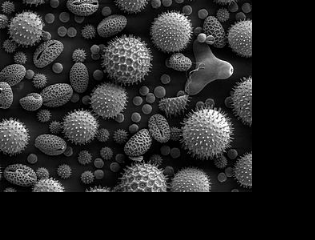

In [8]:
scale(
        xscaling_factor=0.8,
        yscaling_factor=0.8,
        source_filename="cells_scale.png",
        dest_filepath="scaled_out.png",
        file_format="PNG",
    )

Next, we zoom in and scale by $1.3$

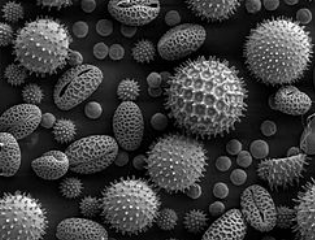

In [9]:
scale(
        xscaling_factor=1.3,
        yscaling_factor=1.3,
        source_filename="cells_scale.png",
        dest_filepath="scaled_in.png",
        file_format="PNG",
    )

We can also scale both axes differently. 

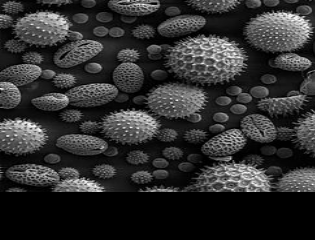

In [10]:
scale(
        xscaling_factor=0.8,
        yscaling_factor=1.3,
        source_filename="cells_scale.png",
        dest_filepath="scaled_xy.png",
        file_format="PNG",
    )

#### 3.2 Results
Interpolation has worked well leaving no blank spots and the scaling works as expected. 